# Affine Calibrators

Notebook to compare different affine estimators of linear functionals. We compare: The (asymptotically) optimally-tuned Butucea-Comte estimator, an oracle Donoho-Minimax estimator that knows the true marginal density (and sets a neighborhood $c_m=2$), and the Donoho-Minimax estimator that estimates the variance based on $M \int Q^2(x)dx$, where $M$ is an upper bound on the marginal density.

In [1]:
using Plots
using EmpiricalBayes
using Distributions

# Marginal Density Estimation

We attempt to estimate the marginal density at $x=1$.

In [3]:
true_dist = MixtureModel([ Normal(-0.3,.5), Normal(1.05,.5)])
marginal_grid = collect(linspace(-7,7,1001));
prior_grid = collect(linspace(-3,3,51));
d_true = NormalConvolutionProblem(true_dist, marginal_grid);
f = BinnedMarginalDensity(d_true);

In [6]:
m = 10_000
butucea_f = EmpiricalBayes.comte_butucea.(marginal_grid, MarginalDensityTarget(1.0), m);

In [4]:
ds = MixingNormalConvolutionProblem(Normal, 0.5, prior_grid, marginal_grid);

In [7]:
M_bd = (marginal_grid[2] - marginal_grid[1])*1/sqrt(2*pi)
M_max_f = MinimaxCalibrator(ds, f, m, MarginalDensityTarget(1.0);
                tol=1e-3, ε=M_bd, C=Inf);

In [8]:
Oracle_donoho_f = MinimaxCalibrator(ds, f, m, MarginalDensityTarget(1.0);
                C=2.0, tol=1e-4, ε=1e-4);


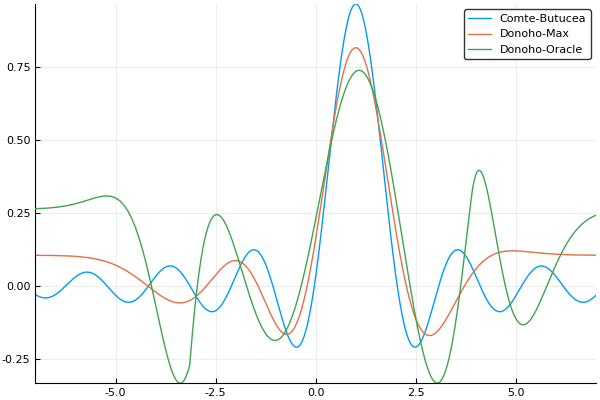

In [9]:
plot(marginal_grid, [butucea_f M_max_f.Q.Q.+M_max_f.Q.Qo Oracle_donoho_f.Q.Q + Oracle_donoho_f.Q.Qo],
     label=["Comte-Butucea" "Donoho-Max" "Donoho-Oracle"])

Let us just get point estimates based on these 3 affine estimators.. 

In [19]:
# truth
f_1 = posterior_stats(d_true, MarginalDensityTarget(1.0))
f_1

0.26898311885002113

In [9]:
srand(1)
Xs = rand(d_true, m); # draw from model

In [10]:
# Comte butucea
mean(BinnedCalibrator(marginal_grid, butucea_f).(Xs))

0.2701005474330966

In [11]:
# Donoho max
mean(M_max_f.Q.(Xs))

0.26994754761669226

In [12]:
# Donoho oracle
mean(Oracle_donoho_f.Q.(Xs))

0.26886482880531337

In [13]:
# finally let us check the CI

donoho_ci(Xs, Oracle_donoho_f, conf=0.9)[2:3]

(0.263037587030755, 0.2746920705798717)

### Quick coverage check:

Let us do the above a bit more systematically

In [14]:
srand(1)
nreps = 1000
est_butucea = Vector{Float64}(nreps)
est_donoho_max = Vector{Float64}(nreps)
est_donoho_oracle = Vector{Float64}(nreps)
coverage_donoho_max = Vector{Bool}(nreps)
width_donoho_max = Vector{Float64}(nreps)
coverage_donoho_oracle = Vector{Bool}(nreps)
width_donoho_oracle = Vector{Float64}(nreps)

for i=1:nreps
    Xs = rand(d_true, m); # draw from model
    est_butucea[i] = mean(BinnedCalibrator(marginal_grid, butucea_f).(Xs))
    donoho_max_ci = donoho_ci(Xs, M_max_f, conf=0.9)
    donoho_oracle_ci = donoho_ci(Xs, Oracle_donoho_f, conf=0.9)
    est_donoho_max[i] = donoho_max_ci[1]
    est_donoho_oracle[i] = donoho_oracle_ci[1]
    coverage_donoho_max[i] = (donoho_max_ci[2] <= f_1 <= donoho_max_ci[3])
    coverage_donoho_oracle[i] = (donoho_oracle_ci[2] <= f_1 <= donoho_oracle_ci[3])
    width_donoho_max[i] = donoho_max_ci[3] - donoho_max_ci[2]
    width_donoho_oracle[i] = donoho_oracle_ci[3] - donoho_oracle_ci[2]
end


Let us check coverage first and average width of CIs

In [15]:
mean(coverage_donoho_max), mean(coverage_donoho_oracle)

(0.919, 0.914)

In [16]:
mean(width_donoho_max), mean(width_donoho_oracle)

(0.012078548627166995, 0.011618154199734396)

Finally let us compare the estimators in terms of their MSE:

In [17]:
mean( (est_butucea - f_1).^2), mean( (est_donoho_max .- f_1).^2), mean( (est_donoho_oracle .- f_1).^2)

(3.6619604575095366e-5, 1.2433559528021454e-5, 1.1453915812007891e-5)

# Numerator of local false sign rate


Now let us do the same as above for the numerator of the local false sign rate.


In [10]:
target = LFSRNumerator(1.0)

EmpiricalBayes.LFSRNumerator(1.0)

In [11]:
butucea_num = EmpiricalBayes.comte_butucea.(marginal_grid, target, m);

We will have to plot our Minimax Calibrator in a separate plot:

In [13]:
M_max_num = MinimaxCalibrator(ds, f, m, target;
                tol=1e-4, ε=M_bd, C=Inf);

In [28]:
Oracle_donoho_num = MinimaxCalibrator(ds, f, m, target;
                C=2.0, tol=1e-4, ε=1e-3);

In [15]:
Oracle_donoho_num_001 = MinimaxCalibrator(ds, f, m, target;
                C=0.001, tol=1e-4, ε=1e-4);


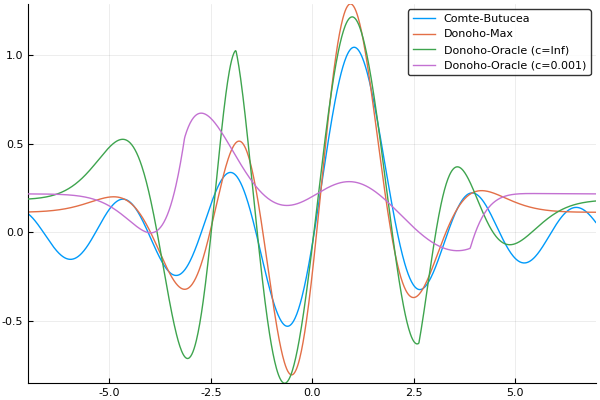

In [29]:
plot(marginal_grid,  [ butucea_num,
        M_max_num.Q.Q.+M_max_num.Q.Qo,
        Oracle_donoho_num.Q.Q.+Oracle_donoho_num.Q.Qo,
        Oracle_donoho_num_001.Q.Q.+Oracle_donoho_num_001.Q.Qo],
         label=["Comte-Butucea" "Donoho-Max" "Donoho-Oracle (c=Inf)" "Donoho-Oracle (c=0.001)"])

In [25]:
M_max_num.max_bias

0.00766300132408702

In [20]:
# truth:
num_true = posterior_stats(d_true, target)
num_true, num_true/f_1

(0.21858844367820998, 0.8126474427567699)

In [21]:
srand(1)
nreps = 1000
est_butucea = Vector{Float64}(nreps)
est_donoho_max = Vector{Float64}(nreps)
est_donoho_oracle = Vector{Float64}(nreps)
est_donoho_oracle2 = Vector{Float64}(nreps)
coverage_donoho_max = Vector{Bool}(nreps)
width_donoho_max = Vector{Float64}(nreps)
coverage_donoho_oracle = Vector{Bool}(nreps)
coverage_donoho_oracle2 = Vector{Bool}(nreps)
width_donoho_oracle = Vector{Float64}(nreps)
width_donoho_oracle2 = Vector{Float64}(nreps)

for i=1:nreps
    Xs = rand(d_true, m); # draw from model
    est_butucea[i] = mean(BinnedCalibrator(marginal_grid, butucea_num).(Xs))
    donoho_max_ci = donoho_ci(Xs, M_max_num, conf=0.9)
    
    donoho_oracle_ci = donoho_ci(Xs, Oracle_donoho_num, conf=0.9)
    donoho_oracle2_ci = donoho_ci(Xs, Oracle_donoho_num_001, conf=0.9)

    est_donoho_max[i] = donoho_max_ci[1]
    est_donoho_oracle[i] = donoho_oracle_ci[1]
    est_donoho_oracle2[i] = donoho_oracle2_ci[1]

    coverage_donoho_max[i] = (donoho_max_ci[2] <= num_true <= donoho_max_ci[3])
    coverage_donoho_oracle[i] = (donoho_oracle_ci[2] <= num_true <= donoho_oracle_ci[3])
    coverage_donoho_oracle2[i] = (donoho_oracle2_ci[2] <= num_true <= donoho_oracle2_ci[3])

    width_donoho_max[i] = donoho_max_ci[3] - donoho_max_ci[2]
    width_donoho_oracle[i] = donoho_oracle_ci[3] - donoho_oracle_ci[2]
    width_donoho_oracle2[i] = donoho_oracle2_ci[3] - donoho_oracle2_ci[2]
end

In [22]:
mean(coverage_donoho_max), mean(coverage_donoho_oracle), mean(coverage_donoho_oracle2)

(0.953, 0.939, 0.994)

In [23]:
mean(width_donoho_max), mean(width_donoho_oracle), mean(width_donoho_oracle2)

(0.032625003246690855, 0.029733340329611092, 0.007741404083659388)

As before, let us compare the MSEs:

In [24]:
mean( (est_butucea .- num_true).^2), mean( (est_donoho_max .- num_true).^2), 
mean( (est_donoho_oracle .- num_true).^2), mean( (est_donoho_oracle2 .- num_true).^2)

(5.4695154595492546e-5, 7.357171567767753e-5, 6.691541898121262e-5, 2.0232532053498074e-6)

Butucea one actually is almost unbiased but has huge variance

In [25]:
mean((est_butucea .- num_true)), std(est_butucea)

(0.005218393299857747, 0.005243187673588728)

## Worst case densities for the above cases:



In [32]:
g1_max = pdf(ds, M_max_num.π1, marginal_grid)
g2_max = pdf(ds, M_max_num.π2, marginal_grid)
g1_oracle = pdf(ds, Oracle_donoho_num.π1, marginal_grid)
g2_oracle = pdf(ds, Oracle_donoho_num.π2, marginal_grid)
g1_oracle2 = pdf(ds, Oracle_donoho_num_001.π1, marginal_grid)
g2_oracle2 = pdf(ds, Oracle_donoho_num_001.π2, marginal_grid);


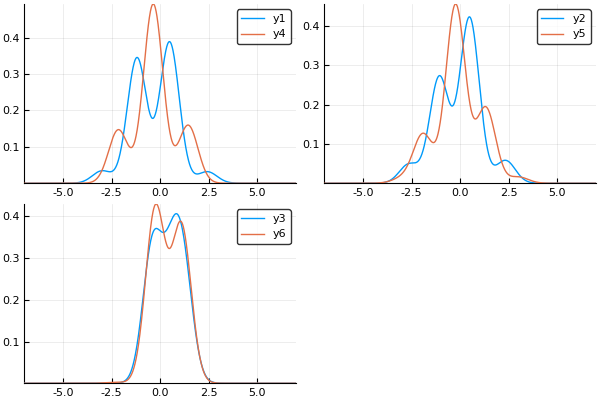

In [33]:
plot(marginal_grid, [g1_max g1_oracle g1_oracle2 g2_max g2_oracle g2_oracle2], layout=3)